# Sentiment Analysis: Machine Learning Approach

### Labeling:

In [114]:
import pandas as pd

def review_labeling(data):
    df = pd.read_csv(data, header=None)
    
    # Apply the condition only to the second column (index 1)
    df[1] = df[1].apply(lambda x: 'positive' if x >= 4 else 'neutral' if 3 <= x < 4 else 'negative')
    
    return df

df_processed = review_labeling('Data/ML/reviews_ML_lightweight.csv')
df_processed.columns = ["Tokens", "Label"]
print(df_processed)
df_processed.to_csv('Data/reviews_label_origin.csv', index=False)

                                                 Tokens     Label
0     Great music service, the audio is high quality...  positive
1     Please ignore previous negative rating. This a...  positive
2     This pop-up "Get the best Spotify experience o...  positive
3       Really buggy and terrible to use as of recently  negative
4     Dear Spotify why do I get songs that I didn't ...  negative
...                                                 ...       ...
9995  Please make sure that the panels don't lag on ...   neutral
9996  This app has become a problem, why do you alwa...  negative
9997  The app is good, but the lyric won't show for ...  positive
9998  Good App..Doesn't have ads between songs and h...  positive
9999  Impossible to use on lock screen anymore. Trie...  negative

[10000 rows x 2 columns]


### Preprocessing:

In [115]:
import numpy as np
import pandas as pd
import spacy
import emoji
import re
import nltk
from tqdm import tqdm
from nltk.sentiment.util import mark_negation


In [116]:
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to map emojis to text. E.g., "Python is 👍" is transformed to "Python is :thumbs_up:"
def map_emojis(text):
    """Convert emojis to their text representations."""
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Replace underscores with spaces in emoji descriptions to avoid them being omitted during tokenization.
    return text.replace('_', ' ')

# Preprocessing function
def preprocess_text(text):
    """Preprocess a single text string."""
    # Lowercase
    text = text.lower()

    # Convert emojis to text
    text = map_emojis(text)

    # Remove URLs and emails
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Tokenization and Lemmatization using spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_stop
    ]
    
    # Apply negation marking
    tokens = mark_negation(tokens)

    return ' '.join(tokens)

tqdm.pandas(desc="Preprocessing Reviews")
df_processed["Tokens"] = df_processed["Tokens"].progress_apply(preprocess_text)

print(df_processed)

df_processed.to_csv('Data/reviews_preprocessed.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Preprocessing Reviews:   6%|▌         | 597/10000 [00:03<01:01, 151.89it/s]


KeyboardInterrupt: 

### Train/Test Splitting:

In [95]:
from sklearn import model_selection as ms

df_text = df_processed[0]
df_target = df_processed[1]

train_data, test_data, train_target, test_target = ms.train_test_split(df_text, df_target, test_size=0.2, random_state=993, stratify=df_target)

print(test_target)


727    negative
177     neutral
329    positive
369     neutral
323     neutral
         ...   
283    positive
391    positive
611    negative
157    positive
601    negative
Name: 1, Length: 150, dtype: object


### Count Vectorizer:

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_features = cv.fit_transform(train_data)

print(train_features.shape)

#print(train_features[:3])

(600, 1459)


In [97]:
from sklearn.preprocessing import Binarizer

transformer = Binarizer()
train_bin = transformer.fit_transform(train_features)
print(train_bin.shape)
print(train_bin[0])

(600, 1459)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (1, 1459)>
  Coords	Values
  (0, 95)	1
  (0, 1186)	1
  (0, 550)	1
  (0, 578)	1
  (0, 937)	1
  (0, 1290)	1
  (0, 1216)	1
  (0, 478)	1


## Classification Process

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

text_clf = Pipeline([('vect', CountVectorizer(min_df=10, max_df=0.5)), 
                     ('binarizer', Binarizer()),
                     ('clf', MultinomialNB()) # Classificiation
                    ])

text_clf.fit(train_data, train_target) 
predicted = text_clf.predict(test_data)


results = pd.DataFrame({
    'Actual': test_target,
    'Predicted': predicted
})

### Confustion Matrix:

Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.82      0.72        60
     neutral       0.33      0.12      0.17        17
    positive       0.85      0.79      0.82        73

    accuracy                           0.73       150
   macro avg       0.61      0.58      0.57       150
weighted avg       0.71      0.73      0.71       150



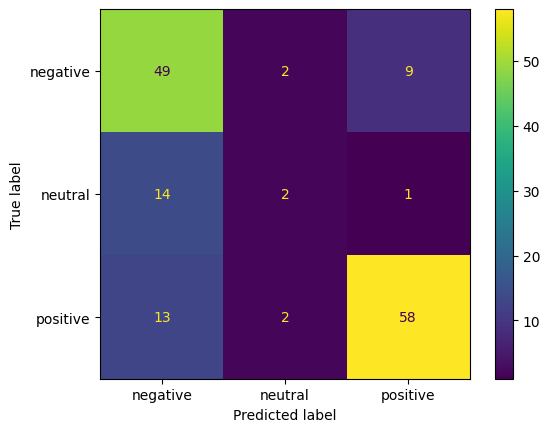

In [111]:
conf_matrix = confusion_matrix(test_target, predicted)
print("Confusion Matrix:")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=text_clf.classes_)
disp.plot()

# Classification Report
report = classification_report(test_target, predicted, target_names=text_clf.classes_)
print("Classification Report:")
print(report)